In [1]:
%cd ..

C:\Users\eakos\Рабочий стол\FIIT\ZNEUS\Project1_zneus_Bioresponse


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import warnings
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold


dataset_path = "./data/phpSSK7iA.csv"

df = pd.read_csv(dataset_path, sep=",")

df.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776,target
0,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,0.243144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,0.106480,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,0.352308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,0.208989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,0.125177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
df.shape

In [3]:
duplicates = df.duplicated()
len(df[duplicates])

0

In [4]:
print(df.isnull().sum().sum())

0


In [46]:
zero_cols = [c for c in df.columns if df[c].notna().all() and (df[c] == 0).all()]

df.drop(columns=zero_cols, inplace=True)

In [ ]:
const_cols = [c for c in df.columns if df[c].dropna().nunique() <= 1]
df.drop(columns=const_cols, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, D1 to target
dtypes: float64(1776), int64(1)
memory usage: 50.9 MB


In [41]:
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols_all if c != 'target']

variance = df[num_cols].var()
print(f"Low variance features (<0.01): {(variance < 0.01).sum()}")

num_of_norm = 0
num_of_not_norm = 0
skipped = 0

for col in num_cols:
    series = df[col].dropna()
    if series.nunique() <= 1:
        skipped += 1
        continue
    sample = series.sample(n=min(5000, len(series)), random_state=42)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            stat, p_value = shapiro(sample)
        except Exception:
            skipped += 1
            continue
    if p_value >= 0.01:
        num_of_norm += 1
    else:
        num_of_not_norm += 1

print(f"Skipped (constant / error): {skipped}")
print(f"Number of features with normality: {num_of_norm}")
print(f"Number of features without normality: {num_of_not_norm}")

Low variance features (<0.01): 852
Skipped (constant / error): 2
Number of features with normality: 0
Number of features without normality: 1820


TARGET ANALYSIS

target
1    2034
0    1717
Name: count, dtype: int64
target
1    0.542255
0    0.457745
Name: proportion, dtype: float64


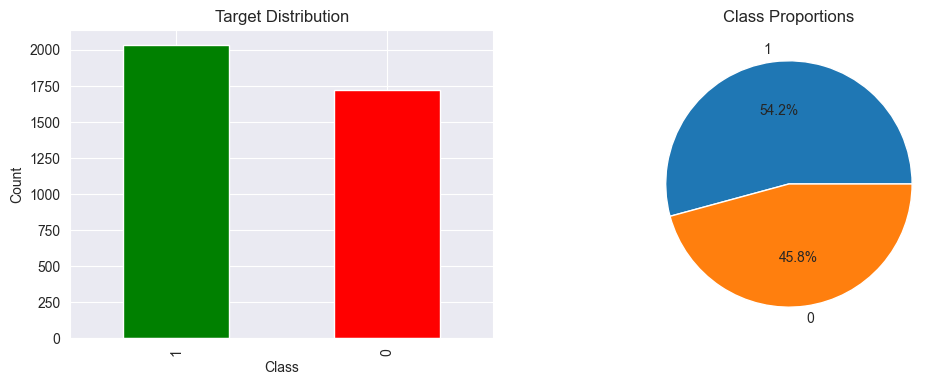

Class imbalance ratio: 0.84


In [42]:
print(df['target'].value_counts())
print(df['target'].value_counts(normalize=True))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df['target'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Target Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

df['target'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Class Proportions')
axes[1].set_ylabel('')
plt.show()


class_ratio = df['target'].value_counts(normalize=True)
print(f"Class imbalance ratio: {class_ratio[0]/class_ratio[1]:.2f}")

if abs(class_ratio[0] - 0.5) > 0.1:
    print("Classes are imbalanced")

BIVARIATE ANALYSIS

Top 20 features by correlation with target:
D27_+_D182     0.481118
D27_+_D469     0.480899
D27_+_D747     0.477074
D27_-_D217     0.476821
D27            0.472340
D27_+_D217     0.451605
D27_-_D747     0.447031
D27_-_D469     0.443701
D27_-_D182     0.440574
D27_x_D217     0.420982
D469_+_D182    0.363690
D27_x_D182     0.363431
D182_+_D747    0.330744
D217_-_D182    0.327531
D27_x_D469     0.282907
D469_-_D217    0.269815
D469           0.268601
D27_x_D747     0.267572
D469_x_D182    0.262106
D469_x_D217    0.262026
dtype: float64


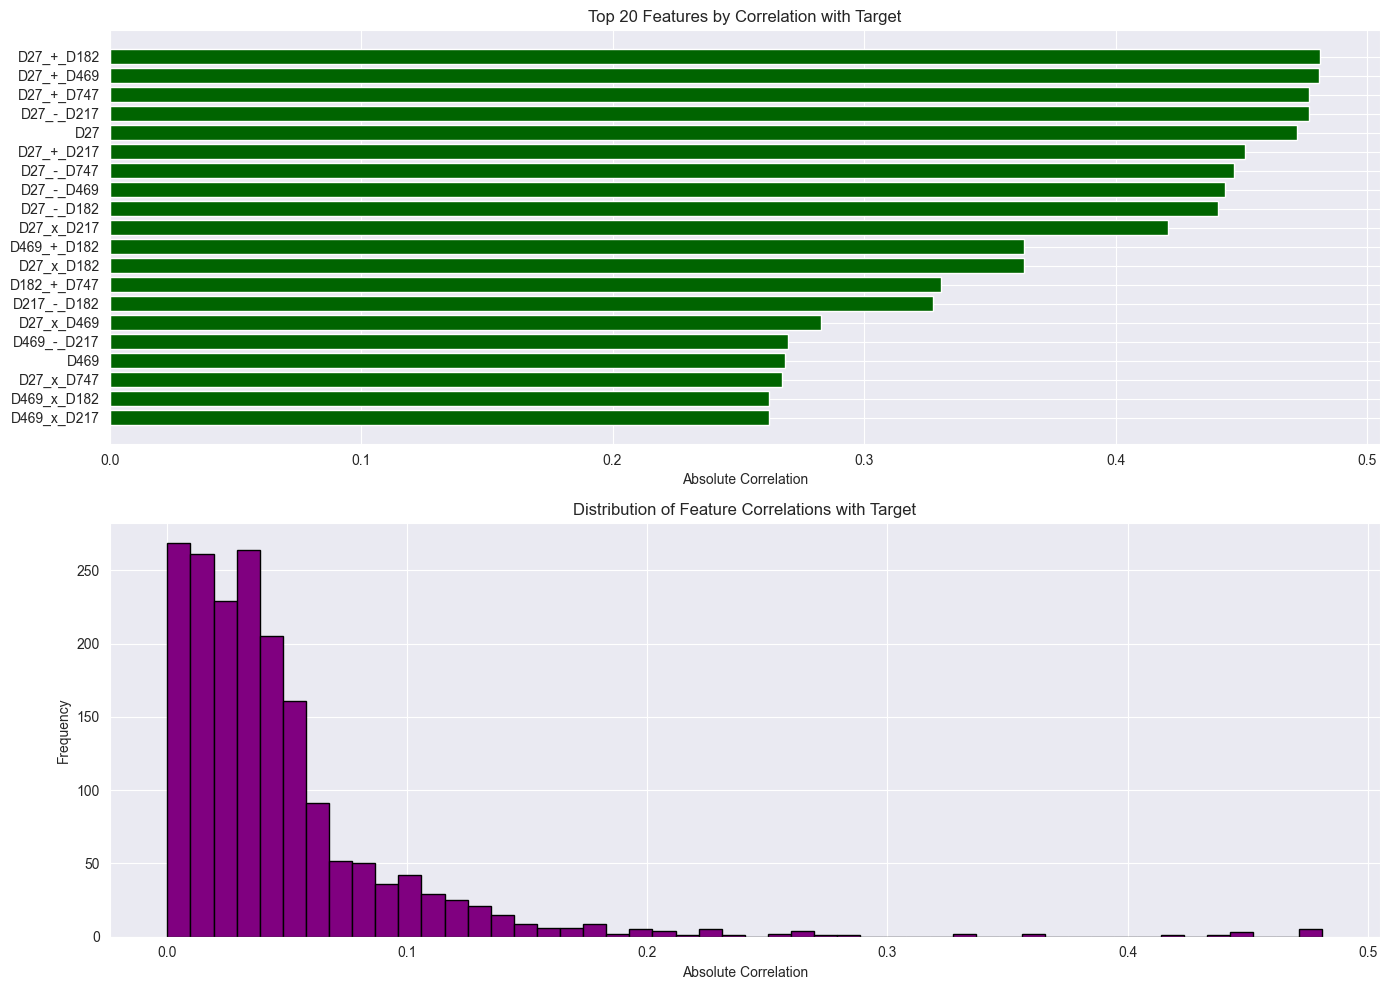

In [48]:
features = [col for col in df.columns if col != 'target']
correlations = df[features].corrwith(df['target']).abs()
correlations = correlations.sort_values(ascending=False)

print("Top 20 features by correlation with target:")
print(correlations.head(20))

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

top_20 = correlations.head(20)
axes[0].barh(range(len(top_20)), top_20.values, color='darkgreen')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20.index)
axes[0].set_xlabel('Absolute Correlation')
axes[0].set_title('Top 20 Features by Correlation with Target')
axes[0].invert_yaxis()

axes[1].hist(correlations, bins=50, edgecolor='black', color='purple')
axes[1].set_xlabel('Absolute Correlation')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Feature Correlations with Target')
plt.tight_layout()
plt.show()

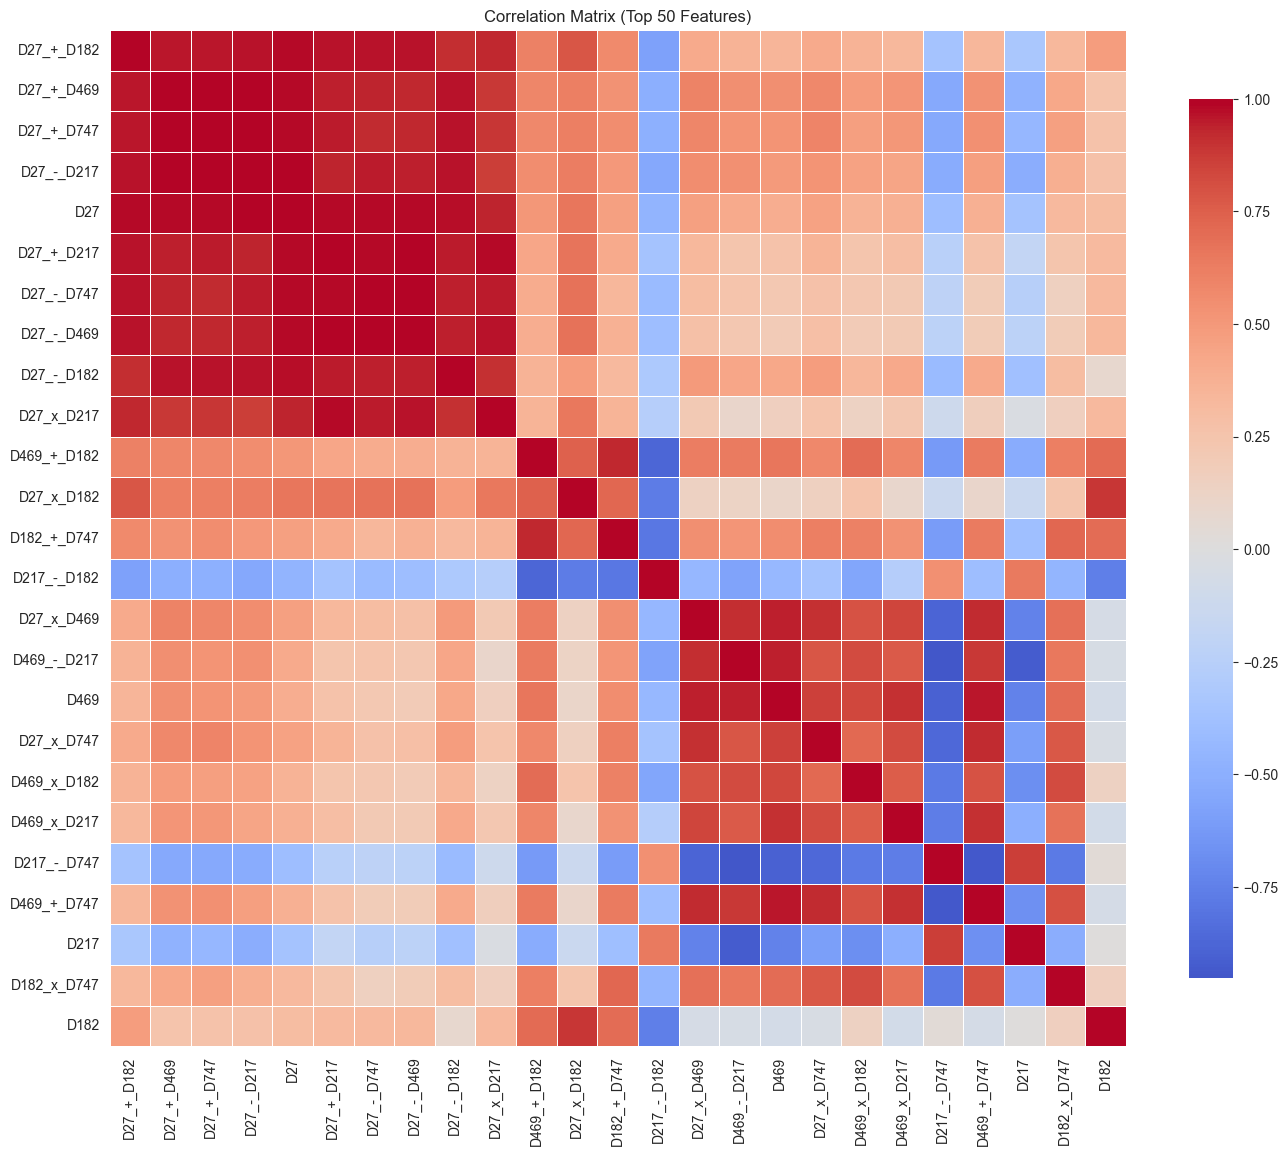

Pairs with correlation > 0.8: 73
D27_+_D469 - D27_+_D747: 0.9945
D27_-_D747 - D27_-_D469: 0.9927
D27_+_D469 - D27_-_D217: 0.9913
D27_+_D217 - D27_-_D469: 0.9883
D27_-_D217 - D27: 0.9865
D27_+_D747 - D27_-_D217: 0.9848
D27_+_D217 - D27_x_D217: 0.9846
D27_+_D469 - D27: 0.9845
D27_+_D747 - D27: 0.9830
D27 - D27_+_D217: 0.9824
Components for 95% variance: 512
Components for 99% variance: 869


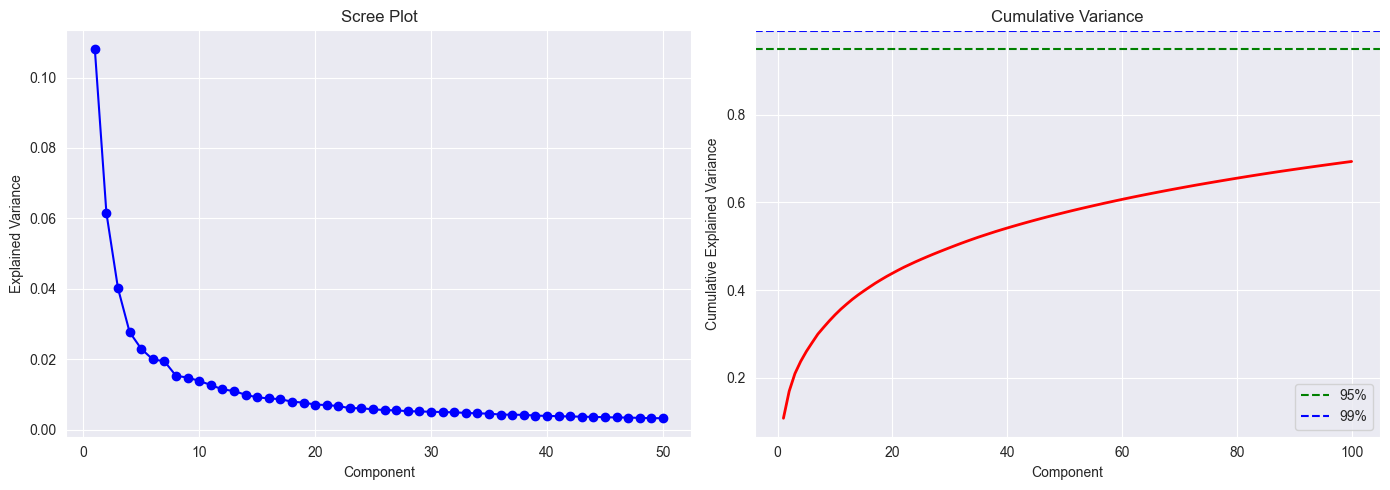

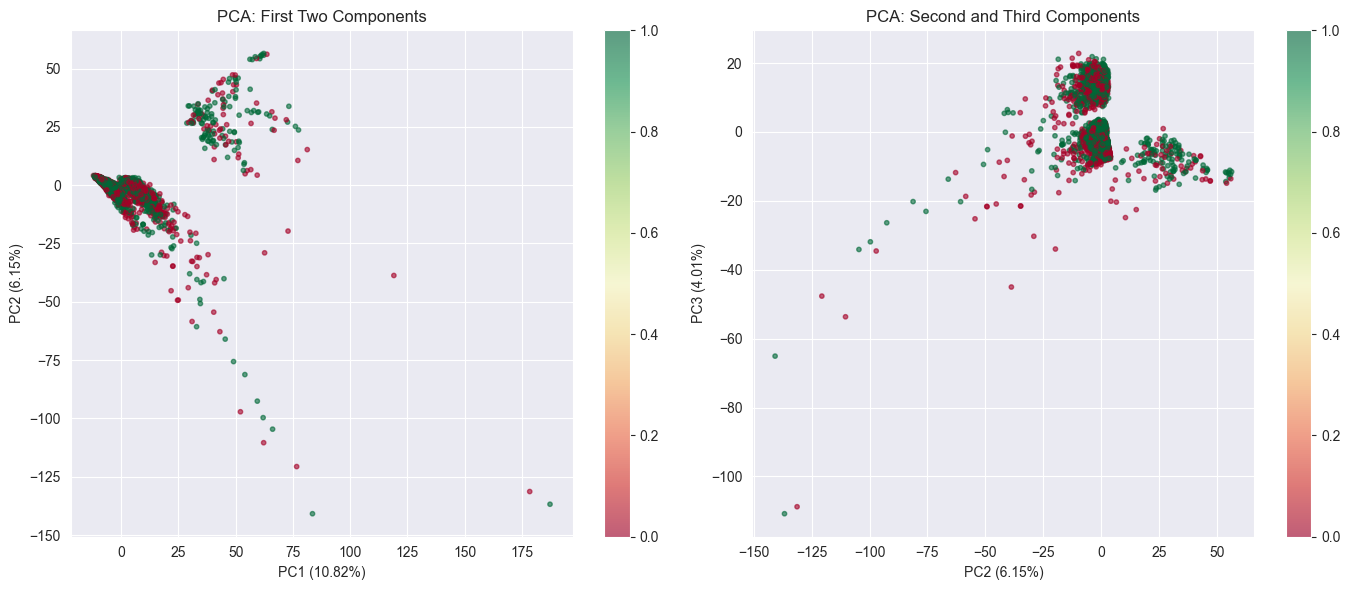

In [44]:
top_25_features = correlations.head(25).index
corr_matrix = df[top_25_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (Top 50 Features)')
plt.tight_layout()
plt.show()

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

print(f"Pairs with correlation > 0.8: {len(high_corr_pairs)}")
for pair in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.4f}")

scaler = StandardScaler()
X = df.drop('target', axis=1)
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
n_comp_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_comp_99 = np.argmax(cumsum_variance >= 0.99) + 1

print(f"Components for 95% variance: {n_comp_95}")
print(f"Components for 99% variance: {n_comp_99}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, 51), pca.explained_variance_ratio_[:50], 'bo-')
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Explained Variance')
axes[0].set_title('Scree Plot')
axes[0].grid(True)

axes[1].plot(range(1, 101), cumsum_variance[:100], 'r-', linewidth=2)
axes[1].axhline(y=0.95, color='g', linestyle='--', label='95%')
axes[1].axhline(y=0.99, color='b', linestyle='--', label='99%')
axes[1].set_xlabel('Component')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance')
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                          c=df['target'], cmap='RdYlGn',
                          alpha=0.6, s=10)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[0].set_title('PCA: First Two Components')
plt.colorbar(scatter, ax=axes[0])

scatter = axes[1].scatter(X_pca[:, 1], X_pca[:, 2],
                          c=df['target'], cmap='RdYlGn',
                          alpha=0.6, s=10)
axes[1].set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')
axes[1].set_title('PCA: Second and Third Components')
plt.colorbar(scatter, ax=axes[1])
plt.tight_layout()
plt.show()

OUTLIER DETECTION

Features with outliers:
1820
Features with most outliers (Z-score > 3):
     feature  n_outliers
1267   D1268         372
1322   D1323         370
1255   D1256         368
1348   D1349         366
1228   D1229         361
1431   D1432         360
1315   D1316         359
1230   D1231         359
1390   D1391         355
1385   D1386         354


Outliers IQR: 1820
Features with most outliers (IQR method):
D469_-_D182    1639
D182_-_D747    1570
D949           1549
D217_+_D182    1448
D217_x_D182    1337
D469_-_D747    1184
D205           1167
D178           1167
D217_+_D747    1122
D469_+_D217    1040
dtype: int64


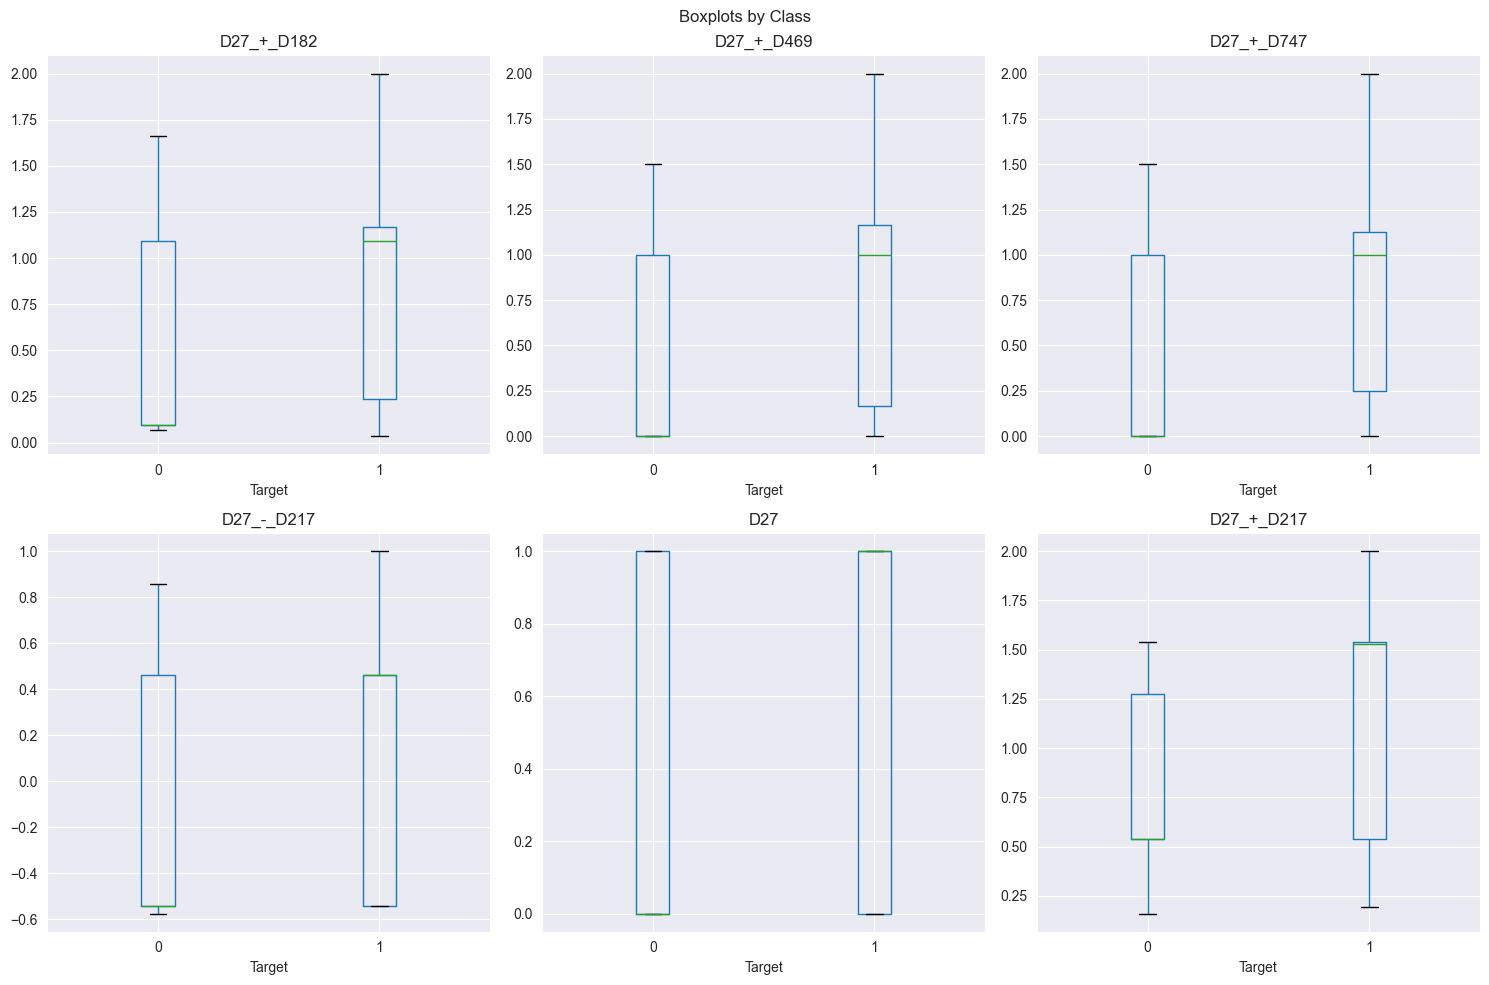


Multivariate outliers detected: 375 (10.00%)


In [54]:
X = df.drop('target', axis=1)
z_scores = np.abs(stats.zscore(X))
outliers = (z_scores > 3).sum(axis=0)

print(f"Features with outliers:\n{len(outliers)}")
print("Features with most outliers (Z-score > 3):")
outlier_df = pd.DataFrame({
    'feature': X.columns,
    'n_outliers': outliers
}).sort_values('n_outliers', ascending=False)
print(outlier_df.head(10))

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).sum()

print(f"\n\nOutliers IQR: {len(outliers_iqr)}")
print("Features with most outliers (IQR method):")
print(outliers_iqr.sort_values(ascending=False).head(10))

top_6_features = correlations.head(6).index
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (ax, feature) in enumerate(zip(axes.flat, top_6_features)):
    df.boxplot(column=feature, by='target', ax=ax)
    ax.set_title(feature)
    ax.set_xlabel('Target')
plt.suptitle('Boxplots by Class')
plt.tight_layout()
plt.show()

iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_labels = iso_forest.fit_predict(X_scaled)
n_outliers = (outlier_labels == -1).sum()
print(f"\nMultivariate outliers detected: {n_outliers} ({n_outliers/len(X)*100:.2f}%)")

FEATURE SELECTION

Features after variance threshold: 970


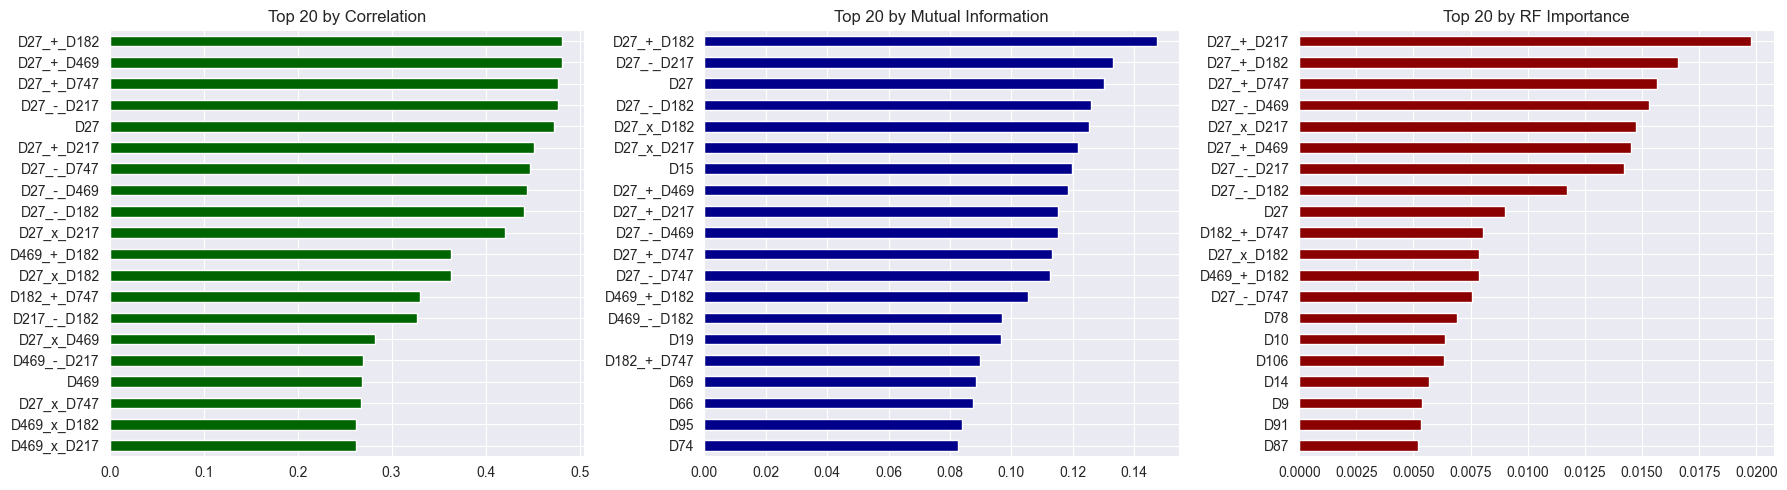


Features in top-100 of all 3 methods: 35
['D177', 'D78', 'D217_x_D747', 'D27_-_D217', 'D27_+_D182', 'D27_+_D747', 'D27_+_D217', 'D27_x_D469', 'pca_3', 'D27_x_D182', 'D8', 'D27_x_D747', 'D27_+_D469', 'D27_x_D217', 'D27_-_D469', 'D64', 'D469_+_D747', 'D66', 'D182_+_D747', 'D659']


In [55]:
selector = VarianceThreshold(threshold=0.01)
X_high_var = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()].tolist()
print(f"Features after variance threshold: {len(selected_features)}")

mi_scores = mutual_info_classif(X, df['target'], random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, df['target'])
feature_importance = pd.Series(rf.feature_importances_,
                               index=X.columns).sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

correlations.head(20).plot(kind='barh', ax=axes[0], color='darkgreen')
axes[0].set_title('Top 20 by Correlation')
axes[0].invert_yaxis()

mi_scores.head(20).plot(kind='barh', ax=axes[1], color='darkblue')
axes[1].set_title('Top 20 by Mutual Information')
axes[1].invert_yaxis()

feature_importance.head(20).plot(kind='barh', ax=axes[2], color='darkred')
axes[2].set_title('Top 20 by RF Importance')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

comparison = pd.DataFrame({
    'correlation': correlations,
    'mutual_info': mi_scores,
    'rf_importance': feature_importance
})

top_by_corr = set(correlations.head(100).index)
top_by_mi = set(mi_scores.head(100).index)
top_by_rf = set(feature_importance.head(100).index)

common_top = top_by_corr & top_by_mi & top_by_rf
print(f"\nFeatures in top-100 of all 3 methods: {len(common_top)}")